## Ustawianie parametrów ręcznie nie pozwalało na zejście z MSE poniżej 2000, poniżej zatem najpierw optymalizacja parametrów backpropagacją a potem widget umożliwiający ręczną zmianę parametrów, ale domyślnie z tymi wcześniej wyznaczonymi. Sieci są uczone a następnie przewidują na danych znormalizowanych, przed obliczaniem MSE cofana jest normalizacja

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np


data = pd.read_csv("../data/regression/square-simple-test.csv")
X = data['x'].values
Y = data['y'].values
x_scaling_factor = max(X)-min(X)
y_scaling_factor = max(Y)-min(Y)
X_scaled = X/x_scaling_factor
Y_scaled = Y/y_scaling_factor

In [130]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, VBox, HBox
import math
import plotly.graph_objects as go
from IPython.display import display, clear_output

## Sieć neuronowa od 0 używana przez widget

In [131]:
class DomowaMLP:
    def __init__(self, n_nodes):
        self.values = [np.zeros(n) for n in n_nodes]
        self.weights = [np.zeros((second,first)) for first, second in zip(n_nodes, n_nodes[1:])]
        self.biases = [np.zeros(n) for n in n_nodes[1:]]

    #returns False if dimensions are improper, changes first layer values  and returns True otherwise
    def set_first_layer_values(self, values):
        if len(values) != len(self.values[0]):
            return False
        self.values[0] = values
        return True

    #returns False if dimensions are improper, changes weights and returns True otherwise
    def set_weights(self, weights):
        if len(self.weights) != len(weights):
            return False
        for curr_weight, prop_weight in zip(self.weights, weights): 
            if curr_weight.shape != prop_weight.shape:
                return False
        self.weights = weights
        return True
        
    #returns False if dimensions are improper, changes weights and returns True otherwise
    def set_biases(self, biases):
        if len(biases) != len(self.biases):
            return False
        self.biases = biases
        return True
        
    #updates nodes values
    def update_nodes(self):
        for i in range(1, len(self.values)):  
            self.values[i] = self.activation_function(
                np.dot(self.weights[i-1], self.values[i-1]) + self.biases[i-1]
            )
            
    def activation_function(self, x):
        return 1 / (1 + np.exp(-x))  

    def get_final_layer_values(self):
        return self.values[-1]
        
    #length on elements of X must equal length of the first layer
    def predict(self, X):
        prediction = []
        for x in X:
            self.set_first_layer_values(x)
            self.update_nodes()
            prediction.append(self.get_final_layer_values())
        return prediction

#Komentarze w tej komórce to na prawdę ja, nie towarzysz gpt

## Krótkie testowanie powyższej klasy

In [132]:
network = DomowaMLP([1, 5, 1])
network.set_weights([np.array([[1], [1], [1], [1],[1]]), np.array([[1, 1, 1, -1, -1]])])

data = pd.read_csv("../data/regression/square-simple-test.csv")

X = data['x'].values
X_tensored = np.expand_dims(X, axis=1)
Y = data['y'].values
Y_pred = network.predict(X_tensored)
Y_pred = [math.log(y[0]/(1-y[0])) for y in Y_pred]
Y_pred = np.array(Y_pred)

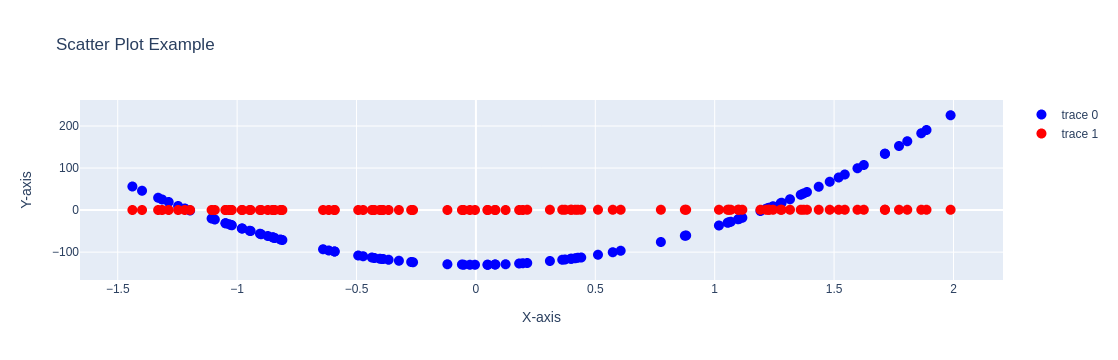

In [133]:
fig = go.Figure(data=go.Scatter(x=X, y=Y, mode='markers', marker=dict(color='blue', size=10)))

fig.add_trace(go.Scatter(x=X, y=Y_pred, mode='markers', marker=dict(color='red', size=10)))

fig.update_layout(title="Scatter Plot Example", xaxis_title="X-axis", yaxis_title="Y-axis")

fig.show()

## Funkcja wyświetlająca widgeta z suwakami 

In [134]:
#brak komentarzy tutaj wcale nie implikuje braku wsparcia pewnych narzędzi
def interactive_mlp(layer_sizes, X, Y, max_sl = 10, min_sl=-10, weights = None, biases = None):
    
    network = DomowaMLP(layer_sizes)

    
    if weights:
        network.set_weights(weights)
    if biases:
        network.set_biases(biases)

    
    weight_sliders = []
    bias_sliders = []
    
    for i in range(len(network.weights)):
        layer_sliders = []
        for j in range(network.weights[i].shape[0]):
            for k in range(network.weights[i].shape[1]):
                slider = widgets.FloatSlider(
                    value=network.weights[i][j, k],
                    #ZAKRES
                    min=min_sl, max=max_sl, step=0.01,
                    description=f"W[{i}][{j},{k}]"
                )
                layer_sliders.append(slider)
        weight_sliders.append(layer_sliders)
    
    for i in range(len(network.biases)):
        layer_bias_sliders = []
        for j in range(len(network.biases[i])):
            slider = widgets.FloatSlider(
                value=network.biases[i][j],
                min=min_sl, max=max_sl, step=0.01,
                description=f"B[{i}][{j}]"
            )
            layer_bias_sliders.append(slider)
        bias_sliders.append(layer_bias_sliders)

    
    plot_output = widgets.Output()

    
    def update_network(*args):
        new_weights = [np.zeros_like(w) for w in network.weights]
        new_biases = [np.zeros_like(b) for b in network.biases]
        
        for i, layer_sliders in enumerate(weight_sliders):
            index = 0
            for j in range(network.weights[i].shape[0]):
                for k in range(network.weights[i].shape[1]):
                    new_weights[i][j, k] = layer_sliders[index].value
                    index += 1
        
        for i, layer_bias_sliders in enumerate(bias_sliders):
            for j in range(len(network.biases[i])):
                new_biases[i][j] = layer_bias_sliders[j].value
        
        network.set_weights(new_weights)
        network.set_biases(new_biases)

        #nienormalność
        x_scaling_factor = max(X) - min(X)
        y_scaling_factor = max(Y) - min(Y)
        X_scaled = X / x_scaling_factor
        Y_scaled = Y / y_scaling_factor
        X_scaled_tensor = np.expand_dims(X_scaled, axis=1)
        
        
        Y_pred_scaled = network.predict(X_scaled_tensor)
        Y_pred_scaled = [math.log(y[0] / (1 - y[0])) for y in Y_pred_scaled]
        Y_pred_scaled = np.array(Y_pred_scaled)
        Y_pred = Y_pred_scaled * y_scaling_factor

        MSE = sum((Y-Y_pred)**2)/len(Y)
        
        with plot_output:
            clear_output(wait=True)
            fig = go.Figure(data=go.Scatter(x=X.flatten(), y=Y, mode='markers', marker=dict(color='blue', size=10), name = "data"))
            fig.add_trace(go.Scatter(x=X.flatten(), y=Y_pred, mode='markers', marker=dict(color='red', size=10), name = "prediction"))
            fig.update_layout(
                title=f"Interactive MLP - MSE: {MSE}",
                xaxis_title="X-axis",
                yaxis_title="Y-axis"
            )
            fig.show()

    
    for layer_sliders in weight_sliders:
        for slider in layer_sliders:
            slider.observe(update_network, names='value')
    
    for layer_bias_sliders in bias_sliders:
        for slider in layer_bias_sliders:
            slider.observe(update_network, names='value')

    
    weight_box = VBox([HBox(layer) for layer in weight_sliders])
    bias_box = VBox([HBox(layer) for layer in bias_sliders])
    display(VBox([weight_box, bias_box, plot_output]))

    
    update_network()


## 1.1 Dane square-simple sieć 2x5

In [81]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.Sigmoid(),
    nn.Linear(5, 5),
    nn.Sigmoid(),
    nn.Linear(5, 1),
)





x_tensor = torch.tensor(X_scaled, dtype=torch.float32).view(-1, 1) 
target = torch.tensor(Y_scaled, dtype=torch.float32).view(-1, 1)  

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.99)

for epoch in range(30000):
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

Epoch 0, Loss: 0.2846
Epoch 1000, Loss: 0.0000
Epoch 2000, Loss: 0.0000
Epoch 3000, Loss: 0.0000
Epoch 4000, Loss: 0.0000
Epoch 5000, Loss: 0.0000
Epoch 6000, Loss: 0.0000
Epoch 7000, Loss: 0.0000
Epoch 8000, Loss: 0.0000
Epoch 9000, Loss: 0.0000
Epoch 10000, Loss: 0.0000
Epoch 11000, Loss: 0.0000
Epoch 12000, Loss: 0.0000
Epoch 13000, Loss: 0.0000
Epoch 14000, Loss: 0.0000
Epoch 15000, Loss: 0.0000
Epoch 16000, Loss: 0.0000
Epoch 17000, Loss: 0.0000
Epoch 18000, Loss: 0.0000
Epoch 19000, Loss: 0.0000
Epoch 20000, Loss: 0.0000
Epoch 21000, Loss: 0.0000
Epoch 22000, Loss: 0.0000
Epoch 23000, Loss: 0.0000
Epoch 24000, Loss: 0.0000
Epoch 25000, Loss: 0.0000
Epoch 26000, Loss: 0.0000
Epoch 27000, Loss: 0.0001
Epoch 28000, Loss: 0.0000
Epoch 29000, Loss: 0.0000
0.weight: tensor([[ 7.5409],
        [-5.1742],
        [-6.3290],
        [-8.0304],
        [ 6.7194]])
0.bias: tensor([-2.3151,  2.6485, -2.4870,  4.7482, -4.1683])
2.weight: tensor([[-1.8026,  0.1761, -3.6799,  0.8072, -2.1121],


In [82]:
#przetwarzanie parametrów wyżej wyznaczonych do postaci strawnej przez widgeta
params = []
for name, param in model.named_parameters():
    params.append(param)
for i in range(len(params)):
    params[i] = params[i].detach().numpy()
weights = [params[0], params[2], params[4]]
biases = [params[1], params[3], params[5]]

In [83]:
interactive_mlp([1, 5, 5, 1], X, Y, 10, -10, weights, biases)

## 1.2 Dane square-simple sieć 1x10

In [48]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1),
)





x_tensor = torch.tensor(X_scaled, dtype=torch.float32).view(-1, 1) 
target = torch.tensor(Y_scaled, dtype=torch.float32).view(-1, 1)  

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.99)

for epoch in range(10000):
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

Epoch 0, Loss: 0.0717
Epoch 1000, Loss: 0.0000
Epoch 2000, Loss: 0.0000
Epoch 3000, Loss: 0.0000
Epoch 4000, Loss: 0.0000
Epoch 5000, Loss: 0.0000
Epoch 6000, Loss: 0.0000
Epoch 7000, Loss: 0.0000
Epoch 8000, Loss: 0.0000
Epoch 9000, Loss: 0.0000
0.weight: tensor([[-6.3012],
        [-0.1356],
        [ 4.3740],
        [-0.3694],
        [-0.1271],
        [-3.4380],
        [-0.4723],
        [-4.9675],
        [ 0.1122],
        [ 0.0433]])
0.bias: tensor([-2.8847, -0.2351, -2.4516, -0.1696, -1.7421, -1.2782, -0.2544,  3.5699,
        -2.4985, -2.6259])
2.weight: tensor([[ 1.2809,  0.2199,  1.7653,  0.2901, -0.0182,  0.4578,  0.1190, -1.2599,
          0.0079,  0.0088]])
2.bias: tensor([0.2735])


In [49]:
pred_scaled = np.squeeze(model(x_tensor).detach().numpy())
pred_descaled = pred_scaled*y_scaling_factor


In [50]:
params = []
for name, param in model.named_parameters():
    params.append(param)
for i in range(len(params)):
    params[i] = params[i].detach().numpy()
weights = [params[0], params[2]]
biases = [params[1], params[3]]

In [51]:
interactive_mlp([1,10,1], X, Y, 10, -10 weights, biases)

## 1.3 Dane square-simple sieć 1x5

In [52]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.Sigmoid(),
    nn.Linear(5, 1),
)





x_tensor = torch.tensor(X_scaled, dtype=torch.float32).view(-1, 1) 
target = torch.tensor(Y_scaled, dtype=torch.float32).view(-1, 1)  

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.99)

for epoch in range(10000):
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

Epoch 0, Loss: 0.0654
Epoch 1000, Loss: 0.0001
Epoch 2000, Loss: 0.0000
Epoch 3000, Loss: 0.0000
Epoch 4000, Loss: 0.0000
Epoch 5000, Loss: 0.0000
Epoch 6000, Loss: 0.0000
Epoch 7000, Loss: 0.0000
Epoch 8000, Loss: 0.0000
Epoch 9000, Loss: 0.0000
0.weight: tensor([[ 1.0959],
        [ 1.2288],
        [-5.0769],
        [-3.9969],
        [-4.9580]])
0.bias: tensor([ 0.7190,  0.5507, -2.3681, -2.4320,  3.1042])
2.weight: tensor([[ 0.7369,  1.1094,  1.4535,  1.2967, -2.3759]])
2.bias: tensor([0.4807])


In [53]:
pred_scaled = np.squeeze(model(x_tensor).detach().numpy())
pred_descaled = pred_scaled*y_scaling_factor

In [54]:
params = []
for name, param in model.named_parameters():
    params.append(param)
for i in range(len(params)):
    params[i] = params[i].detach().numpy()
weights = [params[0], params[2]]
biases = [params[1], params[3]]

In [55]:
interactive_mlp([1,5,1], X, Y, 10, -10 weights, biases)

## 2.1 Dane steps-large sieć 2x5

In [135]:
data = pd.read_csv("../data/regression/steps-large-test.csv")
X = data['x'].values
Y = data['y'].values
x_scaling_factor = max(X)-min(X)
y_scaling_factor = max(Y)-min(Y)
X_scaled = X/x_scaling_factor
Y_scaled = Y/y_scaling_factor

In [88]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.Sigmoid(),
    nn.Linear(5, 5),
    nn.Sigmoid(),
    nn.Linear(5, 1),
)





x_tensor = torch.tensor(X_scaled, dtype=torch.float32).view(-1, 1) 
target = torch.tensor(Y_scaled, dtype=torch.float32).view(-1, 1)  

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.99)

for epoch in range(20000):
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss: {100*loss.item():.4f}")

for name, param in model.named_parameters():
    print(f"{name}: {param.data}")
    

Epoch 0, Loss: 53.5891
Epoch 10000, Loss: 0.0276
0.weight: tensor([[ 94.1106],
        [ 31.5545],
        [ 97.6504],
        [-47.9234],
        [-17.6385]])
0.bias: tensor([ 13.0856,   3.9980, -13.9510,  20.4229,   2.9140])
2.weight: tensor([[-2.5471e+00,  8.7424e-02,  3.6382e+00, -1.0642e+00,  7.8462e-01],
        [-5.2164e+01, -1.5440e+01,  1.2454e+00,  8.8857e+00,  1.1939e+01],
        [-8.2463e+00, -7.6642e+00,  8.7202e+01, -8.8947e+00, -1.7116e+01],
        [-1.6882e+01, -1.6878e+00, -3.8631e-01,  4.7779e+00,  2.2576e+00],
        [ 1.0540e+01,  1.5314e+01,  1.6819e+01, -1.0603e+02, -1.3163e+01]])
2.bias: tensor([ 0.6390,  8.3325, -7.7213,  1.3366,  7.2629])
4.weight: tensor([[-0.0417, -0.4665,  0.3583,  0.1532,  0.3395]])
4.bias: tensor([0.0045])


In [89]:
params = []
for name, param in model.named_parameters():
    params.append(param)
for i in range(len(params)):
    params[i] = params[i].detach().numpy()
weights = [params[0], params[2], params[4]]
biases = [params[1], params[3], params[5]]

In [90]:
interactive_mlp([1, 5, 5, 1], X, Y, 1000, -1000, weights, biases)

## 2.2 Dane steps-large sieć 1x10 (zajęło jakieś 15 prób zanim MSE zeszło poniżej 9 i przy ponownym odpaleniu kodu w cale nie musi)

In [115]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1),
)





x_tensor = torch.tensor(X_scaled, dtype=torch.float32).view(-1, 1) 
target = torch.tensor(Y_scaled, dtype=torch.float32).view(-1, 1)  

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.99)

for epoch in range(500000):
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss: {100*loss.item():.4f}")

for name, param in model.named_parameters():
    print(f"{name}: {param.data}")
    


Epoch 0, Loss: 58.6288
Epoch 10000, Loss: 0.2527
Epoch 20000, Loss: 0.1030
Epoch 30000, Loss: 0.0647
Epoch 40000, Loss: 0.0471
Epoch 50000, Loss: 0.0356
Epoch 60000, Loss: 0.0286
Epoch 70000, Loss: 0.0242
Epoch 80000, Loss: 0.0214
Epoch 90000, Loss: 0.0194
Epoch 100000, Loss: 0.0179
Epoch 110000, Loss: 0.0168
Epoch 120000, Loss: 0.0160
Epoch 130000, Loss: 0.0153
Epoch 140000, Loss: 0.0147
Epoch 150000, Loss: 0.0143
Epoch 160000, Loss: 0.0139
Epoch 170000, Loss: 0.0136
Epoch 180000, Loss: 0.0134
Epoch 190000, Loss: 0.0132
Epoch 200000, Loss: 0.0130
Epoch 210000, Loss: 0.0129
Epoch 220000, Loss: 0.0127
Epoch 230000, Loss: 0.0126
Epoch 240000, Loss: 0.0126
Epoch 250000, Loss: 0.0125
Epoch 260000, Loss: 0.0124
Epoch 270000, Loss: 0.0124
Epoch 280000, Loss: 0.0124
Epoch 290000, Loss: 0.0123
Epoch 300000, Loss: 0.0123
Epoch 310000, Loss: 0.0123
Epoch 320000, Loss: 0.0123
Epoch 330000, Loss: 0.0122
Epoch 340000, Loss: 0.0122
Epoch 350000, Loss: 0.0122
Epoch 360000, Loss: 0.0122
Epoch 370000, 

In [116]:
params = []
for name, param in model.named_parameters():
    params.append(param)
for i in range(len(params)):
    params[i] = params[i].detach().numpy()
weights = [params[0], params[2]]
biases = [params[1], params[3]]

In [117]:
interactive_mlp([1, 10, 1], X, Y, 1000, -1000, weights, biases)

## 2.3 Dane steps-large sieć 1x5 (Tutaj w ogóle nie udało się zejść poniżej 9)

In [151]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.Sigmoid(),
    nn.Linear(5, 1),
)





x_tensor = torch.tensor(X_scaled, dtype=torch.float32).view(-1, 1) 
target = torch.tensor(Y_scaled, dtype=torch.float32).view(-1, 1)  

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.99)

for epoch in range(500000):
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss: {100*loss.item():.4f}")

for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

Epoch 0, Loss: 14.8283
Epoch 10000, Loss: 0.2929
Epoch 20000, Loss: 0.1136
Epoch 30000, Loss: 0.0637
Epoch 40000, Loss: 0.0472
Epoch 50000, Loss: 0.0391
Epoch 60000, Loss: 0.0341
Epoch 70000, Loss: 0.0304
Epoch 80000, Loss: 0.0269
Epoch 90000, Loss: 0.0228
Epoch 100000, Loss: 0.0213
Epoch 110000, Loss: 0.0201
Epoch 120000, Loss: 0.0192
Epoch 130000, Loss: 0.0185
Epoch 140000, Loss: 0.0179
Epoch 150000, Loss: 0.0174
Epoch 160000, Loss: 0.0169
Epoch 170000, Loss: 0.0166
Epoch 180000, Loss: 0.0162
Epoch 190000, Loss: 0.0159
Epoch 200000, Loss: 0.0157
Epoch 210000, Loss: 0.0155
Epoch 220000, Loss: 0.0153
Epoch 230000, Loss: 0.0151
Epoch 240000, Loss: 0.0150
Epoch 250000, Loss: 0.0148
Epoch 260000, Loss: 0.0147
Epoch 270000, Loss: 0.0146
Epoch 280000, Loss: 0.0146
Epoch 290000, Loss: 0.0145
Epoch 300000, Loss: 0.0145
Epoch 310000, Loss: 0.0144
Epoch 320000, Loss: 0.0144
Epoch 330000, Loss: 0.0143
Epoch 340000, Loss: 0.0143
Epoch 350000, Loss: 0.0143
Epoch 360000, Loss: 0.0143
Epoch 370000, 

In [152]:
params = []
for name, param in model.named_parameters():
    params.append(param)
for i in range(len(params)):
    params[i] = params[i].detach().numpy()
weights = [params[0], params[2]]
biases = [params[1], params[3]]

In [153]:
interactive_mlp([1, 5, 1], X, Y, 1000, -1000, weights, biases)